### Simulating a Maintenance Contract

- Notebook content :
- Load the libraries
- Loading the Data
- Transforming the column `order_purchase_timestamp` to the number of days since the last purchase
- Function to get the data for modelization
- Calculate the ARI score over time
- Define time intervals
- Calculate the ARI score for each time interval and visualize the results

#### Goal
To ensure that the clustering model remains stable and accurate over time by monitoring its performance and retraining it as needed. This involves:

1. **Finalizing an Optimized Clustering**: Ensure the clustering model is well-tuned and makes sense from a business perspective.
2. **Simulating Stability Over Time**: Track how stable the clusters are over different time periods.

#### Recommendations
1. **Use ARI (Adjusted Rand Index)**: Measure how similar the clusters are over time to decide when to retrain the model.
2. **Monitor Feature Distribution**: Analyze changes in the distribution of your features over time using graphical methods or statistical tests like the Kolmogorov-Smirnov test.

#### Vigilance Points
- Ensure consistency between the data used for initial training and the data for future predictions.


Date range: 2016-09-04 21:15:19 to 2018-10-17 17:30:18
days_since_last_purchase statistics:
count    96096.000000
mean       289.061928
std        153.646258
min          0.000000
25%        165.000000
50%        270.000000
75%        399.000000
max        772.000000
Name: days_since_last_purchase, dtype: float64
Scores for interval 3 days:
 []
Scores for interval 7 days:
 []
Scores for interval 15 days:
 []
Scores for interval 30 days:
 [0.3908607992493531, 0.35143071925362757, 0.44414211739974063, 0.3747740871203489, 0.24748497076636009, 0.3314314267233097, 0.25909978598080324, 0.3413242064160074, 0.2153052209986107, 0.24274825209007866, 0.3031917185594341, 0.3032521564642751, 0.21948934870109682, 0.21338438935943121, 0.23701880032861908, 0.2878460437680406, 0.25980315952710864, 0.25678029859060564, 0.24868548558946413, 0.14757411135510395, 0.09848159677590028, 0.03113145567457397, 0.0]
Scores for interval 60 days:
 [0.14942859380473128, 0.04177015834547368, 0.1255964401591444, 0.064

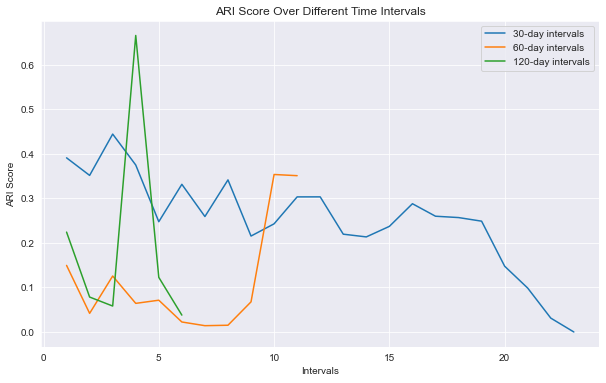

In [4]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
from datetime import datetime

# Set environment variable to suppress the KMeans memory leak warning on Windows
os.environ["OMP_NUM_THREADS"] = "1"

# Load the data
db_path = os.path.join("..", "data")
df_final_kmeans_path = os.path.join(db_path, "df_final_kmeans_with_clusters.csv")
df_final_kmeans = pd.read_csv(df_final_kmeans_path)

# Define the date format
date_format = "%Y-%m-%d %H:%M:%S"  # Adjust this format according to your date format which is 'YYYY-MM-DD HH:MM:SS' in this case

# Identify the available date ranges
min_date_str = df_final_kmeans[
    "order_purchase_timestamp"
].min()  # Minimum date in the dataset as a string format for comparison
max_date_str = df_final_kmeans[
    "order_purchase_timestamp"
].max()  # Maximum date in the dataset as a string format for comparison
min_date = datetime.strptime(
    min_date_str, date_format
)  # Convert the minimum date to a datetime object, e.g. from '2016-09-04 21:15:19' to 2016-09-04 21:15:19
max_date = datetime.strptime(
    max_date_str, date_format
)  # Convert the maximum date to a datetime object, e.g. from '2018-09-03 09:06:57' to 2018-09-03 09:06:57

# Print the Date range which is: 2016-09-04 21:15:19 to 2018-10-17 17:30:18
print(f"Date range: {min_date_str} to {max_date_str}")

# Transform the 'order_purchase_timestamp' column to the number of days since the max date in the dataset
df_final_kmeans["days_since_last_purchase"] = df_final_kmeans[
    "order_purchase_timestamp"
].apply(lambda x: (max_date - datetime.strptime(x, date_format)).days)

# Display unique values of 'days_since_last_purchase'
print("days_since_last_purchase statistics:")
print(df_final_kmeans["days_since_last_purchase"].describe())


# Function to get the data for modeling
def get_data_for_model(data, start_time, interval):
    end_time = start_time + interval
    return data[
        (data["days_since_last_purchase"] >= start_time)
        & (data["days_since_last_purchase"] < end_time)
    ]


# Define specific intervals
frequencies = [3, 7, 15, 30, 60, 120]  # 3, 7, 15, 30, 60, 120 days
scores_dict = {}

# Select only numeric columns for scaling and clustering
numeric_columns = df_final_kmeans.select_dtypes(include=[np.number]).columns.tolist()
numeric_columns.remove("days_since_last_purchase")

# Initial model on the data of D_0
initial_time = df_final_kmeans["days_since_last_purchase"].min()

for interval in frequencies:
    scores = []
    D0 = get_data_for_model(df_final_kmeans, initial_time, interval)

    if not D0.empty and len(D0) >= 4:  # Ensure at least 4 samples
        scaler = RobustScaler()
        D0_scaled = scaler.fit_transform(D0[numeric_columns])
        model_0 = KMeans(n_clusters=4).fit(D0_scaled)  # Use 4 clusters

        # Temporal loop to track the stability of the model
        for t in range(
            int(initial_time) + interval,
            int(df_final_kmeans["days_since_last_purchase"].max()),
            interval,
        ):
            Di = get_data_for_model(df_final_kmeans, t, interval)
            if Di.empty or len(Di) < 4:  # Ensure at least 4 samples
                continue

            Di_scaled = scaler.transform(Di[numeric_columns])
            model_i = KMeans(n_clusters=4).fit(Di_scaled)  # Use 4 clusters

            # Calculate the ARI
            labels_0 = model_0.predict(Di_scaled)
            labels_i = model_i.predict(Di_scaled)
            score = adjusted_rand_score(labels_0, labels_i)
            scores.append(score)

    scores_dict[interval] = scores

# Print ARI scores for each interval
for interval, scores in scores_dict.items():
    print(f"Scores for interval {interval} days:\n", scores)

# Visualize the results
plt.figure(figsize=(10, 6))
for interval, scores in scores_dict.items():
    if scores:
        print(
            f"Plotting scores for interval {interval} days: {scores}"
        )  # Print scores for verification
        plt.plot(range(1, len(scores) + 1), scores, label=f"{interval}-day intervals")
plt.xlabel("Intervals")
plt.ylabel("ARI Score")
plt.title("ARI Score Over Different Time Intervals")
plt.legend()
plt.show()

### Explanation of the ARI Score Over Time Graph

In this context, we're assessing the stability of a clustering model over time. The "intervals" on the x-axis represent the points in time when we check how well the model is performing.

When we say "30-day interval," it means that after every 30 days, we re-evaluate the model's clustering performance. For example:

- At the first interval (1 on the x-axis), we're checking how well the model clusters the data at the end of the first 30 days.
- At the fifth interval (5 on the x-axis), we check how well the model is clustering the data after 150 days (because 5 intervals × 30 days = 150 days).

Each point on the graph represents the Adjusted Rand Index (ARI) score at that specific time interval. The ARI score tells us how similar the clusters are compared to the previous evaluation. A high ARI score means that the clusters have remained stable and consistent over time, while a lower ARI score indicates that the model's clustering results are changing and becoming less consistent.

So, if you see a decline in the ARI score over several intervals, it suggests that the model's ability to maintain consistent clusters is decreasing as time progresses. This might signal the need for re-evaluating or updating the model to ensure it continues to perform well over time.

### Observations

**30-Day Interval**:
- ARI scores start relatively high but gradually decline, with a drastic drop towards the end (from 0.39 to 0.0). This indicates that clusters quickly become inconsistent over time, necessitating frequent re-evaluations to maintain stability.

**60-Day Interval**:
- ARI scores show greater fluctuation with consistently low values (from 0.15 to 0.01), with occasional spikes. This suggests moderate cluster stability, but periodic re-evaluations are required to prevent degradation.

**120-Day Interval**:
- ARI scores vary significantly with a notable peak followed by a drop (from 0.22 to 0.03). The sharp fluctuation indicates that clusters are less stable over this long period, potentially requiring more frequent adjustments despite the goal of long-term stability.

### Graph Interpretation

The graph shows that cluster stability diminishes rapidly over time, especially in shorter periods like 30 days. Longer intervals (60 and 120 days) show similar trends, but with more pronounced fluctuations, indicating that maintaining cluster consistency becomes challenging without regular adjustments.

### Conclusion and Recommendations

1. **Cluster Stability**:
   - Clusters are less stable over shorter periods (30 days), with a sharp decline in consistency, necessitating frequent adjustments.
   - Over longer periods (60 and 120 days), while stability appears moderate, significant fluctuations warrant continuous monitoring.

2. **Model Maintenance**:
   - Re-evaluate clusters every two to four months to ensure reasonable stability without causing excessive adjustments.
   - Regular monitoring at 60-day intervals is recommended to anticipate stability drops.

3. **Continuous Monitoring**:
   - ARI scores should be closely monitored, particularly at 30 to 60-day intervals, to ensure cluster consistency is maintained.
   - Significant drops in ARI scores could indicate the need for a complete re-evaluation of the clusters to maintain performance.

### To update the KMeans model when new customers are added to the database, we have two main approaches:

1. **Retraining the Entire Model**: This involves retraining the KMeans model from scratch with the entire dataset, including the new data. This method ensures that the model captures all data patterns but can be computationally expensive.

2. **Incremental Learning (Partial Fitting)**: While KMeans in scikit-learn does not natively support incremental learning, you can simulate it by clustering the new data separately and then adjusting the existing centroids. This method requires more manual handling but can be efficient for large datasets.

### Example Code for Incremental Learning with KMeans

In [5]:
import os
import pandas as pd
from sklearn.cluster import KMeans

# Load df_final_kmeans with RobustScaler normalization
db_path = os.path.join("..", "data")
df_final_kmeans_path = os.path.join(db_path, "df_final_kmeans.csv")
df_final_kmeans = pd.read_csv(df_final_kmeans_path)

# Ensure that 'order_purchase_timestamp' is a datetime object
df_final_kmeans['order_purchase_timestamp'] = pd.to_datetime(df_final_kmeans['order_purchase_timestamp'])

# Identify the date of the last update (last date of the previous model training)
# Based on the assumption that the model was last trained on the latest data
last_update_date = df_final_kmeans['order_purchase_timestamp'].max()

# Add one day to the last update date to identify new data
next_day = pd.to_datetime(last_update_date) + pd.Timedelta(days=1)

# Check if there are any new customers
new_customers = df_final_kmeans[df_final_kmeans['order_purchase_timestamp'] >= next_day]

if new_customers.empty:
    print("No new customers found to update the model.")
else:
    # Apply the same feature engineering steps as the initial model
    new_customers["RFMScore"] = (
        new_customers["Recency"] * 0.15
        + new_customers["Frequency"] * 0.35
        + new_customers["Monetary"] * 0.50
    )

    # Select relevant features for clustering (data is already normalized)
    features = ["Recency", "Frequency", "Monetary", "RFMScore"]
    X_new = new_customers[features]

    # Load the previously trained KMeans model (assuming you saved it)
    kmeans = KMeans(n_clusters=3, random_state=42)

    # Fit the model incrementally with the new data
    kmeans.partial_fit(X_new)

    # Assign clusters to the new customers
    new_customers["Cluster"] = kmeans.predict(X_new)

    # Append new customers with clusters to the original DataFrame
    df_final_kmeans_updated = pd.concat([df_final_kmeans, new_customers])

    # Save the updated DataFrame with the 'Cluster' column to a new CSV file
    output_path = os.path.join(db_path, "df_final_kmeans_with_clusters_updated.csv")
    df_final_kmeans_updated.to_csv(output_path, index=False)

    print("Model updated with new customers.")


No new customers found to update the model.
